**XGBoost with ADASYN to handle data imbalance**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

Read data

In [ ]:
df = pd.read_csv("../data/fraud_data.csv")
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

Splitting data into train and test set

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Defining column types

In [4]:
numeric = ["amount", "oldbalanceOrg", "newbalanceOrig", "newbalanceDest", "oldbalanceDest"]
categorical = ["type"] 

Preprocewssing data for scaling and handling categorical columns

In [5]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric),
    ("cat", OneHotEncoder(drop="first"), categorical)
])

Defining classifier and making pipeline

In [6]:
xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Pipeline
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(sampling_strategy="minority", random_state=42)),
    ("classifier", xgb_clf)
])

Training the model

In [7]:
# Train
pipeline.fit(X_train, y_train)

c:\Users\Ayush\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:57:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'newbalanceDest',
                                                   'oldbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('adasyn',
                 ADASYN(random_state=42, sampling_strategy='minority')),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

Evaluating the model as per predictions on test set

In [8]:
# Predict
y_pred = pipeline.predict(X_test)
# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[1266484    4397]
 [     10    1633]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.27      0.99      0.43      1643

    accuracy                           1.00   1272524
   macro avg       0.64      1.00      0.71   1272524
weighted avg       1.00      1.00      1.00   1272524



In [9]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_proba = pipeline.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))

ROC-AUC: 0.999517785785019
PR-AUC: 0.819792914328551


Threshold tuning

In [10]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# Predict probabilities for the positive class
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Find precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 for each threshold
f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

# Best threshold
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]
print(f"Best Threshold: {best_threshold:.4f}, F1 Score: {f1[best_idx]:.4f}")

# Apply best threshold
y_pred_opt = (y_proba >= best_threshold).astype(int)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))


Best Threshold: 0.9912, F1 Score: 0.7231
Confusion Matrix:
 [[1269891     990]
 [    152    1491]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.60      0.91      0.72      1643

    accuracy                           1.00   1272524
   macro avg       0.80      0.95      0.86   1272524
weighted avg       1.00      1.00      1.00   1272524



Checking important features

In [11]:
num_features = pipeline.named_steps['preprocessor'].transformers_[0][2]
cat_encoder = pipeline.named_steps['preprocessor'].transformers_[1][1]
cat_feature_names = cat_encoder.get_feature_names_out(categorical)
all_features = list(num_features) + list(cat_feature_names)


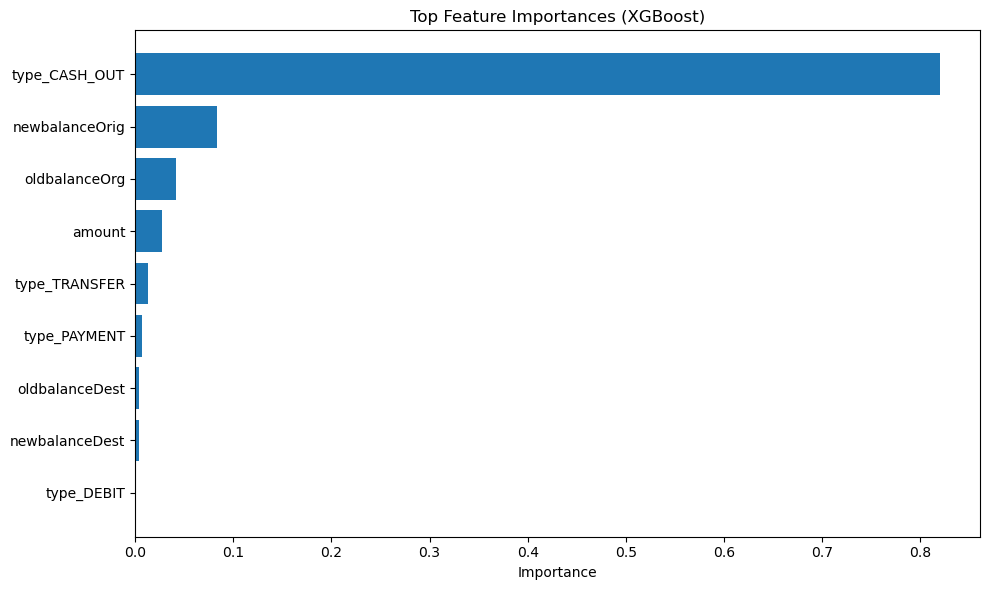

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get trained LightGBM model
lgbm_model = pipeline.named_steps['classifier']

# Get feature importances
importances = lgbm_model.feature_importances_

# Pair features with importance values
feat_imp = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'][:20][::-1], feat_imp['importance'][:20][::-1])
plt.xlabel("Importance")
plt.title("Top Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


Saving model

In [ ]:
import joblib

# Save the model
joblib.dump(pipeline, '../models/XGBoost_ADASYN.pkl')

joblib.dump((X_test, y_test), '../test_data/XGBoost_ADASYN_Test.pkl')

['D:\\IEOR\\3rd Sem\\Fraud detection\\Test\\XGBoost_ADASYN_Test.pkl']